In [1]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# !pip install jupyter-tensorboard
!pip install graphviz
!pip install pydot

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image as tfk_image

import tensorboard 
import datetime
from tensorflow.keras.utils import plot_model

import json
from skimage import io
from pathlib import Path


In [3]:
# tf.keras.backend.clear_session()


In [4]:
# check gpu recognition
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            # tf.config.experimental.set_virtual_device_configuration(gpu,
            #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
            tf.config.experimental.set_memory_growth(gpu, True) 
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


### Overview
Let's test whether we can build a model and memorize training data. The dataset is small and the model should be able to memorize it pretty effectively. This will be a good proof of concept to verify I got my shit together.

This process is "inspired" by the blog at https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/#comment-299

and informed by https://www.tensorflow.org/tutorials/images/segmentation

In [5]:
# some model and tf.dataset args
DEFAULT_IMAGE_SIZE = [512, 512, 3]
DEFAULT_EPOCHS = 400
DEFAULT_BATCH = 8
DEFAULT_LR = 0.5
DEFAULT_MOMENTUM = 0.1
DEFAULT_MODEL_WIDTH_ALPHA = 0.5
DEFAULT_RESIDUAL_LAYER_NAMES = ['input_image',   
                                'block_1_expand_relu',   # 64x64
                                'block_3_expand_relu',   # 32x32
                                'block_6_expand_relu']   # 16x16
DEFAULT_RESIDUAL_LAYER_CHANNELS =  [16, 32, 48, 64]

In [6]:
# let's reuse our janky image read methods
def read_data(path, float_convert=True, scale_fctr=255., return_3D=True):
    # type enforcement for consistency
    if not isinstance(path, (Path, str)):
        path = path.decode()
    if float_convert:
        data = _read_float(path, scale_fctr)
    else:
        data = _read_u8(path, scale_fctr)
    if return_3D:
        data = np.atleast_3d(data)
    return data

def _read_float(path, scale_fctr=1.):
    x = io.imread(path) / scale_fctr
    return x.astype('float32') 

def _read_u8(path, scale_fctr=1):
    x = io.imread(path) / scale_fctr
    return x.astype('uint8')

In [7]:
def tf_parse(x, y, image_size=DEFAULT_IMAGE_SIZE[0]):
    def _parse(x, y):
        x = read_data(x, True)
        y = read_data(y, True, 255.)
        return x, y
    
    # NOTE: need to be careful, not 100% what these are doing
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([image_size, image_size, 3])
    y.set_shape([image_size, image_size, 1])
    return x, y

def tf_dataset(x, y, batch=DEFAULT_BATCH):
    # NOTE: need to be careful, not 100% what these are doing
    print()
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()

    return dataset

In [8]:
# Let's define some params and load our training set
IMG_PATH_KEY, MSK_PATH_KEY, CLASS_KEY = 'images', 'masks', 'building'
data_dir = Path('C:/Users/NPDan/Documents/GitHub/task_challenge/data')

# get that df yo
train_df_path = data_dir / 'train_df.json'
train_df = pd.read_json(train_df_path)
valid_df_path = data_dir / 'valid_df.json'
valid_df = pd.read_json(valid_df_path)


# sanity check
# train_df[IMG_PATH_KEY].unique(), train_df[MSK_PATH_KEY].unique()

In [9]:
train_x = sorted([str(p) for p in Path(train_df[CLASS_KEY].unique()[0].replace('masks','images')).glob('*.png')])
train_y = sorted([str(p) for p in Path(train_df[CLASS_KEY].unique()[0]).glob('*.png')])
valid_x = sorted([str(p) for p in Path(valid_df[CLASS_KEY].unique()[0].replace('masks','images')).glob('*.png')])
valid_y = sorted([str(p) for p in Path(valid_df[CLASS_KEY].unique()[0]).glob('*.png')])

train_dataset = tf_dataset(train_x, train_y, batch=DEFAULT_BATCH)
# valid_dataset = tf_dataset(valid_x, valid_y, batch=DEFAULT_BATCH)
valid_dataset = tf_dataset(train_x, train_y, batch=DEFAULT_BATCH)

Those data loaders and data set methods look good. 

Now, let's try this whole model building thing...

In [10]:
def MobileNetV2_UNet(img_size: list=DEFAULT_IMAGE_SIZE, width_alpha: float=1.,
                     residual_layer_names: list=DEFAULT_RESIDUAL_LAYER_NAMES,
                     residual_layer_channels: list=DEFAULT_RESIDUAL_LAYER_CHANNELS,
                     num_classes=1):
    # defines model input single sample shape
    inputs = Input(shape=img_size, name="input_image")
    
    # Let's breakdown this really quick:
    #     input_shape -> defines input sample size
    #     input_tensor -> optional arg also specifies input sample size
    #     weights -> indicates to use pretrained weights from imagenet
    #     include_top -> indicates whether to retain FCN from original
    #     alpha -> controls network "width", controls filter scaling down the network
    #     encoder_output -> top layer of encoder to start decode path
    encoder = MobileNetV2(input_shape=img_size, input_tensor=inputs, weights="imagenet",
                          include_top=False, alpha=width_alpha)
        
    # ensure to lock encoder weights, get output
    encoder.trainable = False
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    #  build decode path from the bottom-up
    x = encoder_output
    for i in range(1, len(residual_layer_names)+1, 1):
        # Upconv (scales input tensor up by 2x2) and concatenate residual layer (x_skip)
        x_skip = encoder.get_layer(residual_layer_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        # apply 3x3 conv, preserve size (padding="same"), normalize and activate
        x = Conv2D(residual_layer_channels[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        # apply 3x3 conv, preserve size (padding="same"), normalize and activate
        x = Conv2D(residual_layer_channels[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
    # top-level FCN (1x classes conv) and activation
    x = Conv2D(1, (1, num_classes), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [11]:
# original UNet used Dice-coefficient as the loss metric
DEFAULT_SMOOTH_EPS = 1e-15 # avoid divide by zero issues
DEFAULT_NUM_CLASSES = 2 # will need to test this later with  multi-class
def dice_coef(y_true, y_pred, smooth=DEFAULT_SMOOTH_EPS):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def mean_iou(y_true, y_pred, smooth=DEFAULT_SMOOTH_EPS):
    # flatten, calculate IoU and return
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred) + smooth
    union = tf.reduce_sum(tf.maximum(y_true + y_pred, 1.)) # clip to 1.
    return intersection / (union + smooth)


That looks good, let's now define some loss and optimizer components

And here we go... Let's instantiate the model

In [12]:
model = MobileNetV2_UNet(num_classes=DEFAULT_NUM_CLASSES)
opt = tf.keras.optimizers.SGD(DEFAULT_LR, DEFAULT_MOMENTUM)# Blog used - tf.keras.optimizers.Nadam(DEFAULT_LR)
metrics = [dice_coef, Recall(), Precision(), mean_iou]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

# Getting warning because mobilenet doesn't like 512x512 images... Let's see how it goes

Set up some training callbacks to improve training and define some train-loop parameters and then, let 'er rip

In [13]:
##launch TB server
# %tensorboard --logdir ../logs/fit

In [14]:
# configure TB
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# setting monitor = loss should track the training loss, but for reference I've duplicated the
# training data as validation set
# changing patience to hopefully expediite memorization
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=2 ),
#    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.00001),
#    tensorboard_callback
]

# SET training steps
train_steps = len(train_x)//DEFAULT_BATCH
valid_steps = len(train_x)//DEFAULT_BATCH
if len(train_x) % DEFAULT_BATCH != 0:
    train_steps += 1
if len(train_x) % DEFAULT_BATCH != 0: # train and validation set are the same
    valid_steps += 1

In [15]:
def visualize_image_and_mask(x_img, y_true=None, y_pred=None,
                             mask_cmap_name='winter', show_axis=True, title_prefix = ''):
    # plot original
    fig = plt.figure()
    plt.subplot(1,2,1)
    if y_true is not None:
        # overlay mask if applicable
        y_true = y_true.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Truth')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_true, alpha=0.4*y_true, vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
    else:
        plt.title(' '.join((title_prefix, 'Image')))
        plt.imshow(x_img)
    if not show_axis:
        plt.axis('off')
        
    # plot augmented
    if y_pred is not None:
        plt.subplot(1,2,2)
        # overlay mask if applicable
        y_pred = y_pred.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Predicted')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_pred, alpha=0.4*y_pred.squeeze(), vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
        if not show_axis:
            plt.axis('off')
    plt.show()


In [16]:

# plot_model(model, to_file=data_dir/'mnv2un_model_v1.png',
#            show_shapes=True, rankdir='TB', dpi=300)
# plot_model(model)

In [17]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=DEFAULT_EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/400
21/21 [==============================] - 16s 445ms/step - loss: 0.5940 - dice_coef: 0.4060 - recall: 0.7190 - precision: 0.3114 - mean_iou: 0.1205 - val_loss: 0.6232 - val_dice_coef: 0.3768 - val_recall: 0.2532 - val_precision: 0.7909 - val_mean_iou: 0.0712
Epoch 2/400
21/21 [==============================] - 7s 351ms/step - loss: 0.3439 - dice_coef: 0.6561 - recall: 0.7961 - precision: 0.5895 - mean_iou: 0.1419 - val_loss: 0.3549 - val_dice_coef: 0.6451 - val_recall: 0.7567 - val_precision: 0.6743 - val_mean_iou: 0.1388
Epoch 3/400
21/21 [==============================] - 7s 342ms/step - loss: 0.2836 - dice_coef: 0.7164 - recall: 0.8094 - precision: 0.6585 - mean_iou: 0.1439 - val_loss: 0.3209 - val_dice_coef: 0.6791 - val_recall: 0.7429 - val_precision: 0.6955 - val_mean_iou: 0.1363
Epoch 4/400
21/21 [==============================] - 7s 342ms/step - loss: 0.2423 - dice_coef: 0.7577 - recall: 0.8312 - precision: 0.7088 - mean_iou: 0.1472 - val_loss: 0.3335 - val_dice_coef

21/21 [==============================] - 7s 345ms/step - loss: 0.0804 - dice_coef: 0.9196 - recall: 0.9377 - precision: 0.9090 - mean_iou: 0.1633 - val_loss: 0.0887 - val_dice_coef: 0.9113 - val_recall: 0.9293 - val_precision: 0.8989 - val_mean_iou: 0.1640
Epoch 62/400
21/21 [==============================] - 7s 345ms/step - loss: 0.0802 - dice_coef: 0.9198 - recall: 0.9378 - precision: 0.9092 - mean_iou: 0.1633 - val_loss: 0.0885 - val_dice_coef: 0.9115 - val_recall: 0.9296 - val_precision: 0.8990 - val_mean_iou: 0.1640
Epoch 63/400
21/21 [==============================] - 7s 345ms/step - loss: 0.0800 - dice_coef: 0.9200 - recall: 0.9380 - precision: 0.9095 - mean_iou: 0.1634 - val_loss: 0.0883 - val_dice_coef: 0.9117 - val_recall: 0.9298 - val_precision: 0.8992 - val_mean_iou: 0.1640
Epoch 64/400
21/21 [==============================] - 7s 346ms/step - loss: 0.0798 - dice_coef: 0.9202 - recall: 0.9381 - precision: 0.9098 - mean_iou: 0.1634 - val_loss: 0.0881 - val_dice_coef: 0.9119 -

21/21 [==============================] - 7s 346ms/step - loss: 0.0707 - dice_coef: 0.9293 - recall: 0.9444 - precision: 0.9212 - mean_iou: 0.1643 - val_loss: 0.0802 - val_dice_coef: 0.9198 - val_recall: 0.9359 - val_precision: 0.9087 - val_mean_iou: 0.1650
Epoch 122/400
21/21 [==============================] - 7s 347ms/step - loss: 0.0706 - dice_coef: 0.9294 - recall: 0.9445 - precision: 0.9214 - mean_iou: 0.1643 - val_loss: 0.0801 - val_dice_coef: 0.9199 - val_recall: 0.9360 - val_precision: 0.9088 - val_mean_iou: 0.1650
Epoch 123/400
21/21 [==============================] - 7s 345ms/step - loss: 0.0705 - dice_coef: 0.9295 - recall: 0.9446 - precision: 0.9215 - mean_iou: 0.1643 - val_loss: 0.0799 - val_dice_coef: 0.9201 - val_recall: 0.9361 - val_precision: 0.9089 - val_mean_iou: 0.1650
Epoch 124/400
21/21 [==============================] - 7s 345ms/step - loss: 0.0703 - dice_coef: 0.9297 - recall: 0.9447 - precision: 0.9217 - mean_iou: 0.1643 - val_loss: 0.0798 - val_dice_coef: 0.920

21/21 [==============================] - 7s 346ms/step - loss: 0.0635 - dice_coef: 0.9365 - recall: 0.9495 - precision: 0.9299 - mean_iou: 0.1651 - val_loss: 0.0736 - val_dice_coef: 0.9264 - val_recall: 0.9394 - val_precision: 0.9180 - val_mean_iou: 0.1655
Epoch 182/400
21/21 [==============================] - 7s 346ms/step - loss: 0.0634 - dice_coef: 0.9366 - recall: 0.9496 - precision: 0.9300 - mean_iou: 0.1651 - val_loss: 0.0735 - val_dice_coef: 0.9265 - val_recall: 0.9395 - val_precision: 0.9181 - val_mean_iou: 0.1655
Epoch 183/400
21/21 [==============================] - 7s 346ms/step - loss: 0.0633 - dice_coef: 0.9367 - recall: 0.9497 - precision: 0.9302 - mean_iou: 0.1651 - val_loss: 0.0734 - val_dice_coef: 0.9266 - val_recall: 0.9395 - val_precision: 0.9183 - val_mean_iou: 0.1655
Epoch 184/400
21/21 [==============================] - 7s 346ms/step - loss: 0.0632 - dice_coef: 0.9368 - recall: 0.9498 - precision: 0.9303 - mean_iou: 0.1651 - val_loss: 0.0733 - val_dice_coef: 0.926

21/21 [==============================] - 7s 347ms/step - loss: 0.0572 - dice_coef: 0.9428 - recall: 0.9538 - precision: 0.9377 - mean_iou: 0.1657 - val_loss: 0.0675 - val_dice_coef: 0.9325 - val_recall: 0.9436 - val_precision: 0.9256 - val_mean_iou: 0.1661
Epoch 242/400
21/21 [==============================] - 7s 347ms/step - loss: 0.0571 - dice_coef: 0.9429 - recall: 0.9539 - precision: 0.9378 - mean_iou: 0.1657 - val_loss: 0.0674 - val_dice_coef: 0.9326 - val_recall: 0.9437 - val_precision: 0.9257 - val_mean_iou: 0.1661
Epoch 243/400
21/21 [==============================] - 7s 347ms/step - loss: 0.0570 - dice_coef: 0.9430 - recall: 0.9539 - precision: 0.9379 - mean_iou: 0.1657 - val_loss: 0.0673 - val_dice_coef: 0.9327 - val_recall: 0.9438 - val_precision: 0.9258 - val_mean_iou: 0.1661
Epoch 244/400
21/21 [==============================] - 7s 346ms/step - loss: 0.0569 - dice_coef: 0.9431 - recall: 0.9540 - precision: 0.9381 - mean_iou: 0.1657 - val_loss: 0.0672 - val_dice_coef: 0.932

21/21 [==============================] - 7s 348ms/step - loss: 0.0515 - dice_coef: 0.9485 - recall: 0.9580 - precision: 0.9446 - mean_iou: 0.1663 - val_loss: 0.0620 - val_dice_coef: 0.9380 - val_recall: 0.9473 - val_precision: 0.9325 - val_mean_iou: 0.1666
Epoch 302/400
21/21 [==============================] - 7s 348ms/step - loss: 0.0515 - dice_coef: 0.9485 - recall: 0.9580 - precision: 0.9447 - mean_iou: 0.1663 - val_loss: 0.0620 - val_dice_coef: 0.9380 - val_recall: 0.9474 - val_precision: 0.9326 - val_mean_iou: 0.1667
Epoch 303/400
21/21 [==============================] - 7s 348ms/step - loss: 0.0514 - dice_coef: 0.9486 - recall: 0.9581 - precision: 0.9448 - mean_iou: 0.1663 - val_loss: 0.0619 - val_dice_coef: 0.9381 - val_recall: 0.9474 - val_precision: 0.9327 - val_mean_iou: 0.1667
Epoch 304/400
21/21 [==============================] - 7s 349ms/step - loss: 0.0513 - dice_coef: 0.9487 - recall: 0.9581 - precision: 0.9449 - mean_iou: 0.1663 - val_loss: 0.0618 - val_dice_coef: 0.938

21/21 [==============================] - 7s 347ms/step - loss: 0.0466 - dice_coef: 0.9534 - recall: 0.9611 - precision: 0.9510 - mean_iou: 0.1667 - val_loss: 0.0572 - val_dice_coef: 0.9428 - val_recall: 0.9512 - val_precision: 0.9380 - val_mean_iou: 0.1672
Epoch 362/400
21/21 [==============================] - 7s 347ms/step - loss: 0.0465 - dice_coef: 0.9535 - recall: 0.9611 - precision: 0.9511 - mean_iou: 0.1667 - val_loss: 0.0571 - val_dice_coef: 0.9429 - val_recall: 0.9512 - val_precision: 0.9381 - val_mean_iou: 0.1672
Epoch 363/400
21/21 [==============================] - 7s 347ms/step - loss: 0.0464 - dice_coef: 0.9536 - recall: 0.9611 - precision: 0.9512 - mean_iou: 0.1667 - val_loss: 0.0570 - val_dice_coef: 0.9430 - val_recall: 0.9513 - val_precision: 0.9382 - val_mean_iou: 0.1672
Epoch 364/400
21/21 [==============================] - 7s 346ms/step - loss: 0.0463 - dice_coef: 0.9537 - recall: 0.9612 - precision: 0.9513 - mean_iou: 0.1668 - val_loss: 0.0569 - val_dice_coef: 0.943

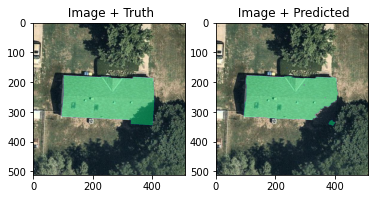

MeanIoU: 0.890


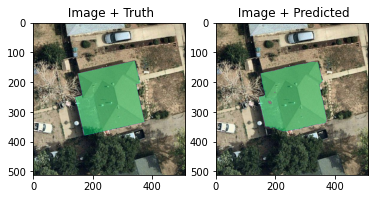

MeanIoU: 0.955


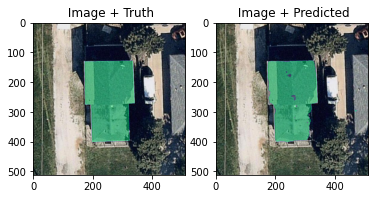

MeanIoU: 0.940


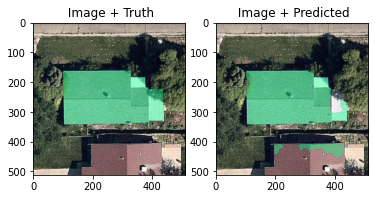

MeanIoU: 0.839


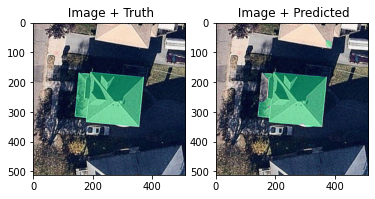

MeanIoU: 0.905


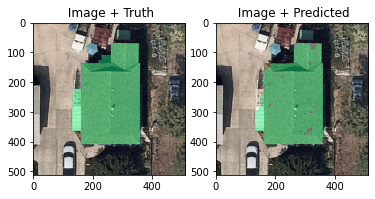

MeanIoU: 0.930


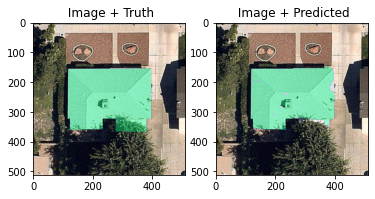

MeanIoU: 0.894


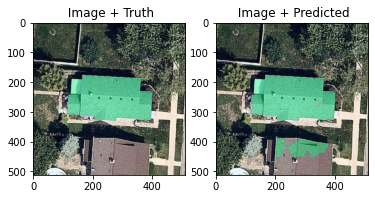

MeanIoU: 0.798


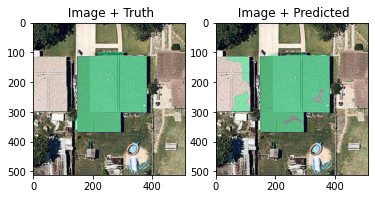

MeanIoU: 0.851


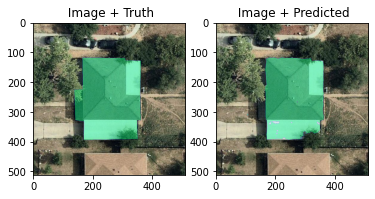

MeanIoU: 0.903


In [18]:
# let's check the output
for i, (x, y) in enumerate(zip(train_x[100:110], train_y[100:110])):
    x = read_data(Path(x), True)
    y = read_data(Path(y), True)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    visualize_image_and_mask(x, y, y_pred)
    print(f'MeanIoU: {np.logical_and(y>0, y_pred).sum()/np.logical_or(y>0, y_pred).sum():.3f}')
    

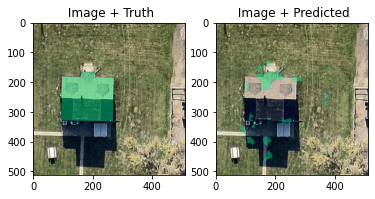

MeanIoU: 0.126


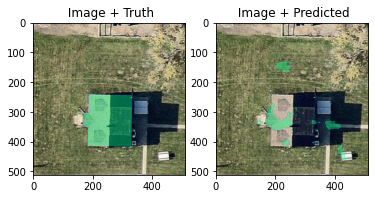

MeanIoU: 0.151


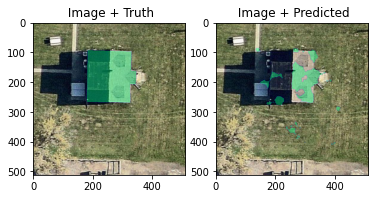

MeanIoU: 0.329


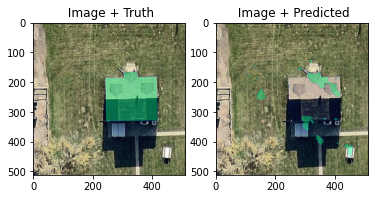

MeanIoU: 0.142


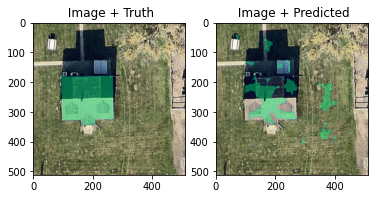

MeanIoU: 0.401


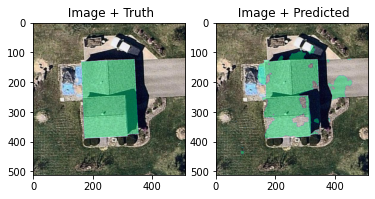

MeanIoU: 0.684


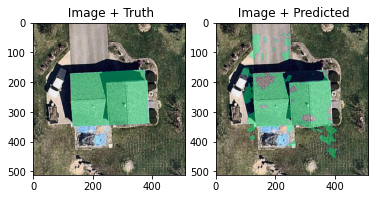

MeanIoU: 0.622


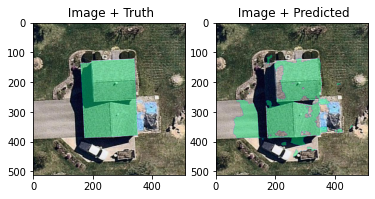

MeanIoU: 0.583


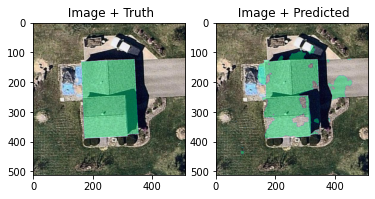

MeanIoU: 0.684


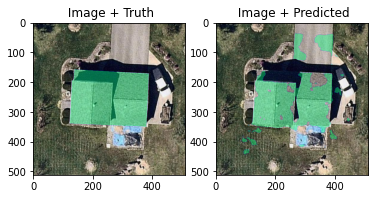

MeanIoU: 0.637


In [19]:
# let's check the output
for i, (x, y) in enumerate(zip(valid_x[100:110], valid_y[100:110])):
    x = read_data(Path(x), True)
    y = read_data(Path(y), True)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    visualize_image_and_mask(x, y, y_pred)
    print(f'MeanIoU: {np.logical_and(y>0, y_pred).sum()/np.logical_or(y>0, y_pred).sum():.3f}')
    

Alright, the model has nearly memorized the training set. Looking at the validation results, it is generalizing better than expected, but not good enough. Good to know at least this model is learning. What next?